# **Text Classification and Topic Modelling Project**






**Part 1: Text Classification**

Two algorithms, namely Recurrent (RNN) and Logistics Regression (LR), are used to develop machine learning models that carry out text classification. In total, 24 models are developed, each configured differently by applying a specific text preprocessing method, being trained on a specific amount of data, and estimating a specific output variable. Their performances would be evaluated to find a more suitable method for this particular problem.


**Part 2: Topic Modelling**

Latent Dirichlet Allocation (LDA) models are developed in order to provide different approaches of document clustering. The first approach takes into consideration bi-grams occurring within the documents and clusters them into 20 topics; whereas, the second approach only processes uni-grams and classifies documents into 10 topics.  For each of the two aforementioned approaches, two models are developed using the small and large training datasets containing the first 1000 and 20,000 records of the original training dataset respectively.

# **Pre-processing**

## I. Configuration

In order to carry the entire program to operation, the following configurations have to be done beforehand.

* This piece of code allows Google Drive File System to access the current Drive system containing this program.

In [ ]:
# Mount Drive system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* The `pyLDAvis` library is installed to visualize data generated in Part 2. The installation is carried out by uncommenting the following piece of code.

In [ ]:
# Install pyLDAvis
# !pip install pyLDAvis==2.1.2

* The following chunk of codes imports all of the necessary libraries supporting the operation of this program.

In [ ]:
# Import nessesary libraries for this program
import warnings

import torch
import torch.nn as nn
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset
import torch.optim as optim

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, RocCurveDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pyLDAvis.gensim
import copy
from collections import Counter

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


* The `nltk` library requires the following datasets to be installed to support its operation. 

In [ ]:
# Download data supporting the operation of the libraries
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## II. Data Loading

The two train and test dataframes are loaded by the piece of code below before being further processed in Part 1 and 2 of this program. Columns are renamed to avoid having them being matching Python's keywords. 
The CSV files are uploaded on to Google Drive at the following location: `My Drive/assignment1_data`

In [ ]:
# Specify column names for the dataframes
column_names=['id', 'url', 'date', 'title', 'info_theory', 'comp_vis', 'mathematics', 'abstract_txt']

# Read data from the CSV files
df_train = pd.read_csv("axcs_train.csv", header=1, names=column_names)
df_test = pd.read_csv("axcs_test.csv", header=1, names=column_names)

# Drop missing values from the testing dataframe
df_test = df_test.dropna()

# Ensure that the label columns contains Integers
df_test["info_theory"] = df_test["info_theory"].astype(int)
df_test["comp_vis"] = df_test["comp_vis"].astype(int)
df_test["mathematics"] = df_test["mathematics"].astype(int)

# **Part 1:  Text Classification**

In this part of the program, text classification is carried out using two different algorithms, namely Logistics Regression and Recurrent Neural Network (RNN). Together with each algorithm, different uses of text pre-proccessing techniques are used to train and test multiple machine learning models before their performances are evaluated.  

* For further operations in Part 1B, a new CSV file containing the test data is generated.

In [ ]:
# Export the test data to a new CSV file
df_test.to_csv("/content/drive/My Drive/assignment1_data/new_axcs_test.csv", index=False)

* From the original training dataframe, a small version it is extracted containing the first 1000 records.

In [ ]:
# Create a small training dataframe from the original training data frame
df_train_small = df_train[:1000]
# Export the small train data to a new CSV file
df_train_small.to_csv("/content/drive/My Drive/assignment1_data/new_axcs_train.csv", index=False)

* Two techniques of text-preprocessing that are going to be used in this part are Stopwords Removal and Snowball Stemming. Before the stopwords are removed or the words are stemmed, the words would be converted to lowercases and numbers are removed.

In [ ]:
# Define the function to remove stopwords from a string
def remove_stopwords(target):  
  # Convert to lowercase
  result = target.lower()
  # Remove numbers
  result = [word for word in result.split() if not word.isnumeric()]
  
  # Get the English stopwords
  english_stopwords = stopwords.words("english") 
  # Remove the stopwords and return the result
  result = [word for word in result if word not in english_stopwords] 
  return result


# Define the function to stem words in a string
def snowball_stemming(target):
  # Convert to lowercase
  result = target.lower()
  # Remove numbers
  result = [word for word in result.split() if not word.isnumeric()]
  
  # Generate the semmer
  stemmer = SnowballStemmer(language='english')
  # Stem the words and return the result
  result = [stemmer.stem(word) for word in result]
  return result
  
# Create a variable representing the function
pre_processing_stopwords = lambda x: remove_stopwords(x)
pre_processing_stemming = lambda x: snowball_stemming(x)

* The following function is defined to draw the ROC curve using the FPR and TPR arrays.

In [ ]:
# Define the function to draw the ROC curve
def draw_ROC(fpr, tpr):
  # Calculate the AUC value
  roc_auc = auc(fpr, tpr)
  # Create the plot
  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
  # Draw the plot
  display.plot() 
  plt.show() 

* In order to evaluate all of the models' performances, their metrics are stored in the following list.

In [ ]:
# This list contains all models' metrics
metrics_summary = list()

## Part 1A: Statistical Method

Logistics Regression is used to train and test the text classification models generated in this part. The models are generated to predict values of the three Boolean variables, namely InfoTheory (renamed as `info_theory`), CompVis (renamed as `comp_vis`), and Math (renamed as `mathematics`).

### I. Stopwords Removal

Each sequence of text would be vectorized before being used to train and test the model. The following vectorizer converts the texts into TF-IDF vectors after tokenizing and removing stopwords from it. This vectorizer only takes into consideration unigrams that appear in more than 10% of the documents.

In [ ]:
# Create the vectorizer
vectorizer_stopwords = TfidfVectorizer(analyzer='word', input='content', lowercase=True, 
                                       token_pattern='(?u)\\b\\w\\w+\\b', min_df=0.1, ngram_range=(1,1), 
                                       tokenizer=pre_processing_stopwords)

#### 1. Large Train Data

In this section the entire train data would be used.

In [ ]:
# Specify the input variables
x_train = vectorizer_stopwords.fit_transform(df_train.abstract_txt.tolist())
x_test = vectorizer_stopwords.transform(df_test.abstract_txt.tolist())

##### 1.1. InfoTheory

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train.info_theory.tolist())
y_test = np.asarray(df_test.info_theory.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

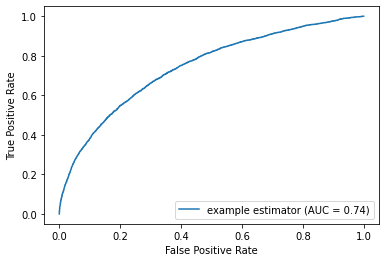

In [ ]:
# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stopwords",
    "data_size": "large",
    "target": "info_theory",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.2. CompVis

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train.comp_vis.tolist())
y_test = np.asarray(df_test.comp_vis.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

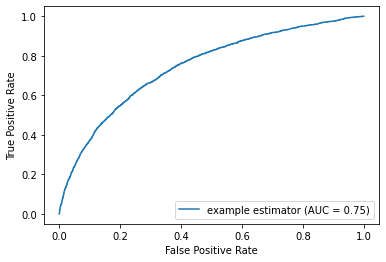

In [ ]:
# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stopwords",
    "data_size": "large",
    "target": "comp_vis",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.3. Math

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train.mathematics.tolist())
y_test = np.asarray(df_test.mathematics.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

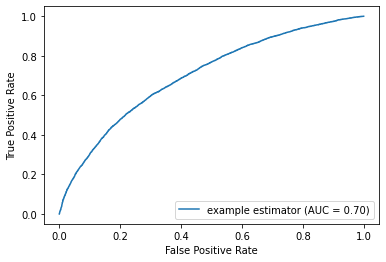

In [ ]:
# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stopwords",
    "data_size": "large",
    "target": "mathematics",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

#### 2. Small Train Data

In this section only the first 1000 records of the train data would be used.

In [ ]:
# Specify the input variables
x_train = vectorizer_stopwords.fit_transform(df_train_small.abstract_txt.tolist())
x_test = vectorizer_stopwords.transform(df_test.abstract_txt.tolist())

##### 2.1. InfoTheory

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train_small.info_theory.tolist()) 
y_test = np.asarray(df_test.info_theory.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

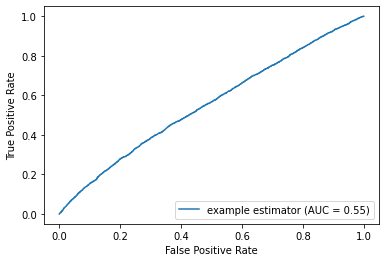

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stopwords",
    "data_size": "small",
    "target": "info_theory",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.2. CompVis

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train_small.comp_vis.tolist()) 
y_test = np.asarray(df_test.comp_vis.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

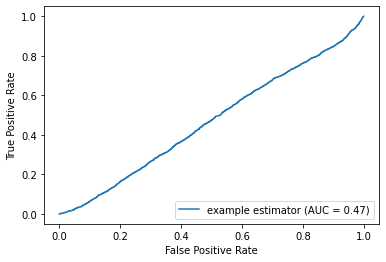

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stopwords",
    "data_size": "small",
    "target": "comp_vis",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.3. Math

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train_small.mathematics.tolist()) 
y_test = np.asarray(df_test.mathematics.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

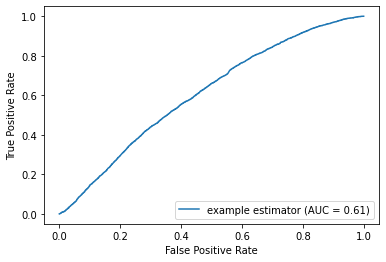

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stopwords",
    "data_size": "small",
    "target": "mathematics",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

### II. Snowball Stemming

Each sequence of text would be vectorized before being used to train and test the model. The following vectorizer converts the texts into TF-IDF vectors after tokenizing and stemming each one of the generated token. This vectorizer only takes into consideration unigrams that appear in more than 10% of the documents.

In [ ]:
vectorizer_stemming = TfidfVectorizer(analyzer='word', input='content', lowercase=True, 
                                      token_pattern='(?u)\\b\\w\\w+\\b', min_df=0.1, ngram_range=(1,1), 
                                      tokenizer=pre_processing_stemming)

#### 1. Large Train Data

In [ ]:
# Specify the input variables
x_train = vectorizer_stemming.fit_transform(df_train.abstract_txt.tolist())
x_test = vectorizer_stemming.transform(df_test.abstract_txt.tolist())

##### 1.1. InfoTheory

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train.info_theory.tolist())
y_test = np.asarray(df_test.info_theory.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

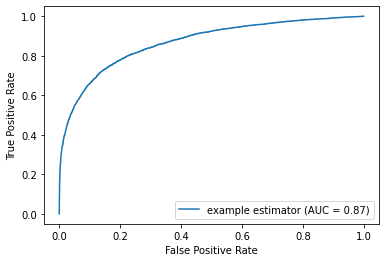

In [ ]:
# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stemming",
    "data_size": "large",
    "target": "info_theory",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.2. CompVis

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train.comp_vis.tolist())
y_test = np.asarray(df_test.comp_vis.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

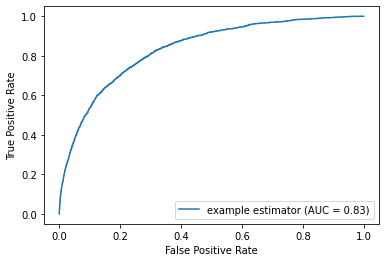

In [ ]:
# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stemming",
    "data_size": "large",
    "target": "comp_vis",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.3. Math

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train.mathematics.tolist())
y_test = np.asarray(df_test.mathematics.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

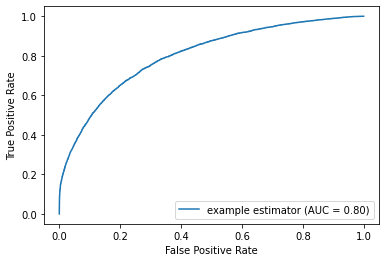

In [ ]:
# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stemming",
    "data_size": "large",
    "target": "mathematics",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

#### 2. Small Train Data

In this section only the first 1000 records of the train data would be used.

In [ ]:
# Specify the input variables
x_train = vectorizer_stemming.fit_transform(df_train_small.abstract_txt.tolist())
x_test = vectorizer_stemming.transform(df_test.abstract_txt.tolist())

##### 2.1. InfoTheory

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train_small.info_theory.tolist())
y_test = np.asarray(df_test.info_theory.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

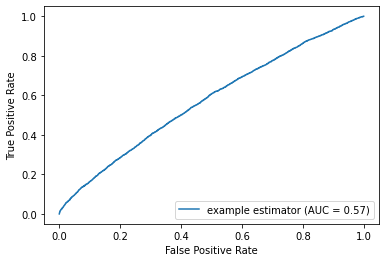

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stemming",
    "data_size": "small",
    "target": "info_theory",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.2. CompVis

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train_small.comp_vis.tolist())
y_test = np.asarray(df_test.comp_vis.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

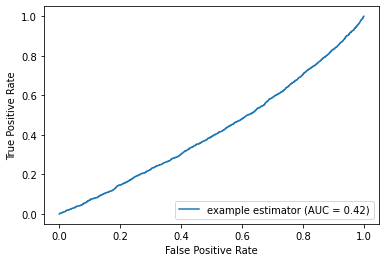

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stemming",
    "data_size": "small",
    "target": "comp_vis",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.3. Math

In [ ]:
# Specify the output variables
y_train = np.asarray(df_train_small.mathematics.tolist())
y_test = np.asarray(df_test.mathematics.tolist())

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Create the model
classi_model = LogisticRegression(random_state=1234)

# Train the model
classi_model.fit(x_train, y_train)

# Make predictions
y_pred = classi_model.predict(x_test)
y_prob = classi_model.predict_proba(x_test)[:, 1]

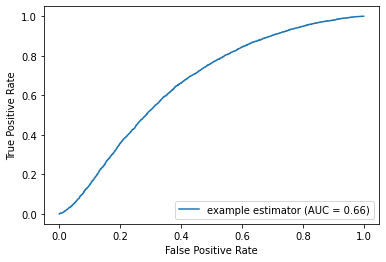

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Calculate FPR and TPR
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Save model's performance into the summary list
performance = {
    "algorithm": "lr",
    "pre_processing": "stemming",
    "data_size": "small",
    "target": "mathematics",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, average='macro'),
    "recall": recall_score(y_test, y_pred, average='macro'),
    "f1": f1_score(y_test, y_pred, average='macro'),
    "fpr": fpr,
    "tpr": tpr
}
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

## Part 1B: RNN Method

RNN is used to train and test the text classification models generated in this part. The models are generated to predict values of the three Boolean variables, namely InfoTheory (renamed as `info_theory`), CompVis (renamed as `comp_vis`), and Math (renamed as `mathematics`).

* This piece of code sets seed for the program to ensure its consistency and decides if the models can be loaded to GPU.

In [ ]:
# Set the seed
torch.manual_seed(1234)
torch.backends.cudnn.deterministic=True

# Create the variable to load models to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

* The structure of each RNN model is defined below.

In [ ]:
# Structure of RNN model
class RNN(nn.Module):

  # Specify the layers of the model
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim): 
    super().__init__()
    self.embedding = nn.Embedding(input_dim, embedding_dim) # Embedding layer
    self.rnn = nn.RNN(embedding_dim, hidden_dim) # Hidden layer
    self.fc = nn.Linear(hidden_dim, output_dim) # Output layer
      
  # Define the function to feed data into the model
  def forward(self, text):
    embedded = self.embedding(text)  # Pass data to Embedding layer
    output, hidden = self.rnn(embedded) # Pass data to Hidden and Output layer
    assert torch.equal(output[-1,:,:], hidden.squeeze(0)) # Verify the result
    return self.fc(hidden.squeeze(0)) # Return result

* The following piece of code defines how each RNN model is trained using the given Optimizer and Loss Function. The `target` variable specify the output variable of the model.

In [ ]:
# Define the model training function
def train(model, iterator, optimizer, loss_func, target):

  # Store the total loss 
  epoch_loss = 0

  # Start training the model
  model.train()

  # Use each batch of data to train the model
  for batch in iterator:

    # Clear gradient from previous iteration
    optimizer.zero_grad() 
    
    # Feedforward
    predictions = model(batch.abstract_txt).squeeze(1)

    # Calculate loss based on the output variable
    if target == "info_theory":
      loss = loss_func(predictions, batch.info_theory)
    elif target == "comp_vis":
      loss = loss_func(predictions, batch.comp_vis)
    elif target == "mathematics":
      loss = loss_func(predictions, batch.mathematics)
    else:
      return "Invalid input"

    # Backward propagation
    loss.backward()

    # Update the parameters
    optimizer.step()

    # Add up the loss
    epoch_loss += loss.item()
      
  # Return the average loss
  return epoch_loss/len(iterator)

* The following piece of code defines how each RNN model's performance is evaluated. The `target` variable specify the output variable of the model.

In [ ]:
# Define the function to evaluate RNN models
def evaluate(model, iterator, target):
  y_pred = list() # List of predictions
  y_test = list() # List of true labels
  y_prob = list() # List of prediction probabilities

  # Start evaluating the model
  model.eval()
  with torch.no_grad():
    # Use each batch of data to test the model
    for batch in iterator:
      # Calculated the prediction probabilities
      probs = torch.sigmoid(rnn_model(batch.abstract_txt).squeeze(1))
      y_prob += probs.tolist()

      # Make predictions
      preds = torch.round(probs)
      y_pred += preds.tolist()

      # Get the true labels based on the output variable
      if target == "info_theory":
        y_test += batch.info_theory.tolist()
      elif target == "comp_vis":
        y_test += batch.comp_vis.tolist()
      elif target == "mathematics":
        y_test += batch.mathematics.tolist()
      else:
        return "Invalid input"

  # Convert the lists to numpy arrays
  y_pred = np.asarray(y_pred)
  y_test = np.asarray(y_test)
  y_prob = np.asarray(y_prob)

  # Calculate FPR and TPR
  fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

  # Return the metrics
  result = {
      "accuracy": accuracy_score(y_test, y_pred),
      "precision": precision_score(y_test, y_pred, average='macro'),
      "recall": recall_score(y_test, y_pred, average='macro'),
      "f1": f1_score(y_test, y_pred, average='macro'),
      "fpr": fpr,
      "tpr": tpr
  }
  return result

In [ ]:
# Specify the datatype of the output variable
LABEL = data.LabelField(dtype=torch.float, use_vocab=False, preprocessing=int)

### I. Stopwords Removal

In this section, the stopwords are removed from the input variable .

* The input variable would come in the `TEXT` form specified below with stopwords removed from it.

In [ ]:
# Specify the datatype of the input variable
TEXT = data.Field(sequential=True, tokenize=pre_processing_stopwords, lower=True)

In [ ]:
# Specify the datatype of the train and test dataframes
data_fields = [("id", None), ("url", None),("date", None), ("title", None), 
               ("info_theory", LABEL), ("comp_vis", LABEL), ("mathematics", LABEL), 
               ("abstract_txt", TEXT)]

In [ ]:
# Read the train and test dataframes from the CSV files
train_data, test_data = TabularDataset.splits(
    path='/content/drive/My Drive/assignment1_data', 
    train='axcs_train.csv', 
    test='new_axcs_test.csv', 
    format='csv',
    skip_header=True,
    fields=data_fields)

# Read the small train dataframe from the CSV file
train_data_small = TabularDataset(
    path='/content/drive/My Drive/assignment1_data/new_axcs_train.csv', 
    format='csv',
    skip_header=True,
    fields=data_fields)

In [ ]:
# Create the test batches using the test dataframe
test_iterator = data.BucketIterator(
    dataset=test_data, 
    batch_size=32,
    device=device,
    sort_key=lambda x: len(x.abstract_txt),
    sort_within_batch=False)

#### 1. Large Train Data

In this section the entire train data would be used. Data would be distributed into multiple batches with size 32.

* Words embedding is carried out using pre-trained GloVe vectors instead of randomly initialized. The vectors are 200-dimensional and pre-trained on 6 billion tokens.

In [ ]:
# Build the vocabulary on the train data
TEXT.build_vocab(train_data, max_size=5000, vectors="glove.6B.200d", unk_init=torch.Tensor.normal_)

.vector_cache/glove.6B.zip: 862MB [02:45, 5.21MB/s]                           
100%|█████████▉| 399968/400000 [00:26<00:00, 14678.35it/s]

In [ ]:
# Create the train batches using the train dataframe
train_iterator = data.BucketIterator(
    dataset=train_data, 
    batch_size=32,
    device=device,
    sort_key=lambda x: len(x.abstract_txt),
    sort_within_batch=False)

# Start the iterator
batch_train = next(train_iterator.__iter__())

##### 1.1. InfoTheory

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "info_theory")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

100%|█████████▉| 399968/400000 [00:40<00:00, 14678.35it/s]

<All keys matched successfully>

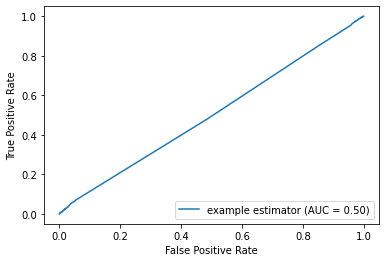

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "info_theory")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stopwords",
    "data_size": "large",
    "target": "info_theory",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.2. CompVis

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "comp_vis")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

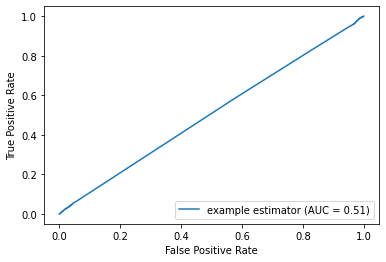

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "comp_vis")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stopwords",
    "data_size": "large",
    "target": "comp_vis",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.3. Math

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "mathematics")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

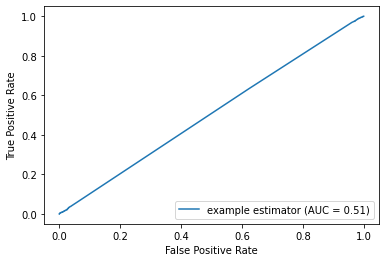

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "mathematics")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stopwords",
    "data_size": "large",
    "target": "mathematics",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

#### 2. Small Train Data

In this section only the first 1000 records of the train data would be used. Data would be distributed into multiple batches with size 32.

* Words embedding is carried out using pre-trained GloVe vectors instead of randomly initialized. The vectors are 200-dimensional and pre-trained on 6 billion tokens.

In [ ]:
# Build the vocabulary on the train data
TEXT.build_vocab(train_data_small, max_size=5000, vectors="glove.6B.200d", unk_init=torch.Tensor.normal_)

In [ ]:
# Create the train batches using the train dataframe
train_iterator = data.BucketIterator(
    dataset=train_data_small, 
    batch_size=32,
    device=device,
    sort_key=lambda x: len(x.abstract_txt),
    sort_within_batch=False)

# Start the iterator
batch_train = next(train_iterator.__iter__())

##### 2.1. InfoTheory

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "info_theory")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

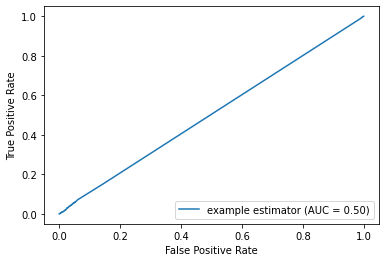

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "info_theory")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stopwords",
    "data_size": "small",
    "target": "info_theory",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.2. CompVis

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "comp_vis")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

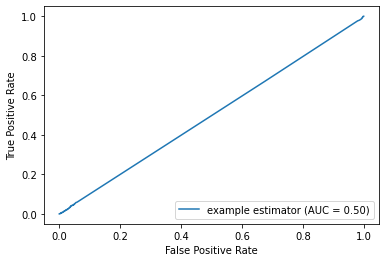

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "comp_vis")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stopwords",
    "data_size": "small",
    "target": "comp_vis",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.3. Mathematics

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "mathematics")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

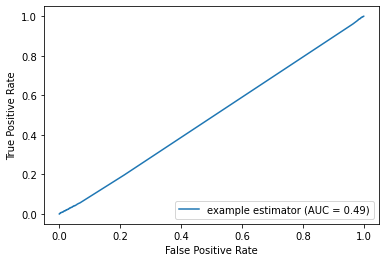

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "mathematics")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stopwords",
    "data_size": "small",
    "target": "mathematics",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

### II. Snowball Stemming

In this section, words in the input variable are stemmed.

* The input variable would come in the `TEXT` form specified below with each of the word stemmed.

In [ ]:
# Specify the datatype of the input variable
TEXT = data.Field(sequential=True, tokenize=pre_processing_stemming, lower=True)

In [ ]:
# Specify the datatype of the train and test dataframes
data_fields = [("id", None), ("url", None),("date", None), ("title", None), 
               ("info_theory", LABEL), ("comp_vis", LABEL), ("mathematics", LABEL), 
               ("abstract_txt", TEXT)]

In [ ]:
# Read the train and test dataframes from the CSV files
train_data, test_data = TabularDataset.splits(
    path='/content/drive/My Drive/assignment1_data', 
    train='axcs_train.csv', 
    test='new_axcs_test.csv', 
    format='csv',
    skip_header=True,
    fields=data_fields)

# Read the small train dataframe from the CSV file
train_data_small = TabularDataset(
    path='/content/drive/My Drive/assignment1_data/new_axcs_train.csv', 
    format='csv',
    skip_header=True,
    fields=data_fields)

In [ ]:
# Create the test batches using the test dataframe
test_iterator = data.BucketIterator(
    dataset=test_data, 
    batch_size=32,
    device=device,
    sort_key=lambda x: len(x.abstract_txt),
    sort_within_batch=False)

#### 1. Large Train Data

In this section the entire train data would be used. Data would be distributed into multiple batches with size 32.

* Words embedding is carried out using pre-trained GloVe vectors instead of randomly initialized. The vectors are 200-dimensional and pre-trained on 6 billion tokens.

In [ ]:
# Build the vocabulary on the train data
TEXT.build_vocab(train_data, max_size=5000, vectors="glove.6B.200d", unk_init=torch.Tensor.normal_)

In [ ]:
# Create the train batches using the train dataframe
train_iterator = data.BucketIterator(
    dataset=train_data, 
    batch_size=32,
    device=device,
    sort_key=lambda x: len(x.abstract_txt),
    sort_within_batch=False)

# Start the iterator
batch_train = next(train_iterator.__iter__())

##### 1.1. InfoTheory

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "info_theory")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

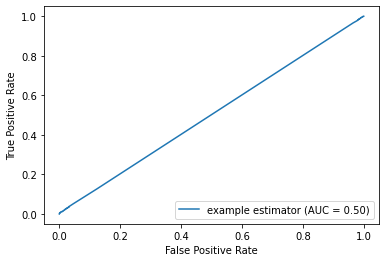

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "info_theory")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stemming",
    "data_size": "large",
    "target": "info_theory",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.2. CompVis

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "comp_vis")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

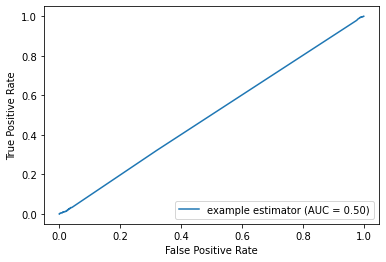

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "comp_vis")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stemming",
    "data_size": "large",
    "target": "comp_vis",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 1.3. Mathematics

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "mathematics")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

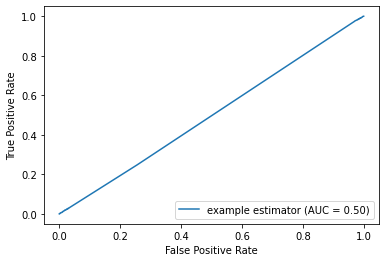

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "mathematics")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stemming",
    "data_size": "large",
    "target": "mathematics",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

#### 2. Small Train Data

In this section only the first 1000 records of the train data would be used. Data would be distributed into multiple batches with size 32.

* Words embedding is carried out using pre-trained GloVe vectors instead of randomly initialized. The vectors are 200-dimensional and pre-trained on 6 billion tokens.

In [ ]:
# Build the vocabulary on the train data
TEXT.build_vocab(train_data_small, max_size=5000, vectors="glove.6B.200d", unk_init=torch.Tensor.normal_)

In [ ]:
# Create the train batches using the train dataframe
train_iterator = data.BucketIterator(
    dataset=train_data_small, 
    batch_size=32,
    device=device,
    sort_key=lambda x: len(x.abstract_txt),
    sort_within_batch=False)

# Start the iterator
batch_train = next(train_iterator.__iter__())

##### 2.1. InfoTheory

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "info_theory")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

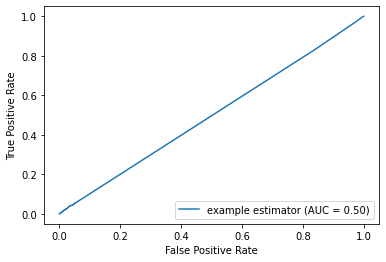

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "info_theory")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stemming",
    "data_size": "small",
    "target": "info_theory",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.2. CompVis

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "comp_vis")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

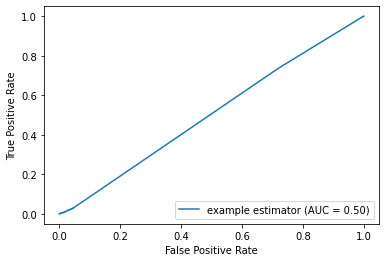

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "comp_vis")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stemming",
    "data_size": "small",
    "target": "comp_vis",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

##### 2.3. Mathematics

* The following RNN model has 200 embedding dimensions, 400 hidden dimensions, and 1 output dimension.

In [ ]:
# Generate the model and place it on GPU
rnn_model = RNN(len(TEXT.vocab), 200, 400, 1).to(device)
# Generate the optimizer
optimizer = optim.SGD(rnn_model.parameters(), lr=3e-3)
# Generate the loss function and place it on GPU
loss_func = nn.BCEWithLogitsLoss().to(device)

In [ ]:
# Record the best loss
best_train_loss = float('inf')

# Train the model
for epoch in range(5):
    train_loss = train(rnn_model, train_iterator, optimizer, loss_func, "mathematics")
    
    # Save the best model with the lowest loss
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(rnn_model.state_dict(), 'RNN_model.pt')

# Load the model
rnn_model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

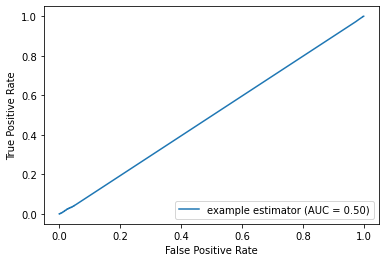

In [ ]:
# Evaluate model's performance
performance = evaluate(rnn_model, test_iterator, "mathematics")

# Add data and store the performance record
performance.update({
    "algorithm": "rnn",
    "pre_processing": "stemming",
    "data_size": "small",
    "target": "mathematics",
})
metrics_summary.append(performance)

# Draw the ROC curve
draw_ROC(performance['fpr'], performance['tpr'])

## Part 1C:  Methods Evaluation

* In order to further examine the performances of all models, the list containing their metrics is converted to Pandas dataframe using the piece of code below.

In [ ]:
# Convert the list of all models' metrics to dataframe
metrics_summary_df = pd.DataFrame(metrics_summary)

* The piece of code below summarize the average Accuracy, Precision, Recall, and F1 scores of Logistics Regression and RNN.

In [ ]:
# Average metrics for LR and RNN
metrics_summary_df[['algorithm', 'accuracy', 'precision', 'recall', 'f1']].groupby(['algorithm']).mean()

,accuracy,precision,recall,f1
algorithm,,,,
lr,0.816579,0.580926,0.547442,0.521249
rnn,0.799749,0.517475,0.500085,0.446894


* Overall, to the extent of this study, it can be concluded that LR outperformed RNN, when models developed using this algorithm provide results that outweigh those of its counterpart. As illustrated in the table above, the average Accuracy, Precision, Recall, and F1 Score of LR are all higher than those of RNN. However, despite the fact that both algorithms have their Accuracy of approximately 80%, their other 3 metrics are noticeably lower when they vary around roughly 50%. 

In [ ]:
# Average metrics for LR and RNN developed using on small and large train data
metrics_summary_df[['algorithm', 'data_size', 'accuracy', 'precision', 'recall', 'f1']].groupby(['algorithm','data_size']).mean()

accuracy  precision    recall        f1
algorithm data_size                                         
lr        large      0.831326   0.760935  0.594884  0.598571
          small      0.801833   0.400916  0.500000  0.443926
rnn       large      0.801570   0.540564  0.500536  0.445853
          small      0.797928   0.494386  0.499635  0.447934

* By examining the ROC curves of each model, it is noticeable that in the case of LR, when models are trained using only the first 1000 records of the training dataset, the resulted ROC curves are very likely to take the shape of diagonal lines. Nonetheless, when the entire training dataset is used to develop the models, the curves take convex forms.

* The piece of code below summarize the average Accuracy, Precision, Recall, and F1 scores of models using Snowball Stemming and Stopwords Removal.

In [ ]:
# Average metrics of models using stemming and stopwords removal
metrics_summary_df[['pre_processing', 'accuracy', 'precision', 'recall', 'f1']].groupby(['pre_processing']).mean()

,accuracy,precision,recall,f1
pre_processing,,,,
stemming,0.812654,0.557321,0.535001,0.498107
stopwords,0.803675,0.541080,0.512527,0.470035


* It can be seen that models that use Snowball Stemming as their text preprocessing method perform better than ones that apply Stopwords Removal. 

* The advantage of Snowball Stemming over Stopwords Removal can be further noticed through the ROC curves generated when LR models are developed using the large training dataset. The curves of models using Snowball Stemming have a higher level of convexity (due to the higher AUC numbers) compared ones resulted from models applying Stopwords Removal.

* The following piece of code counts the labels of each output variables in the large train dataframe.

In [ ]:
# Create a dataframe to count labels
label_counting = pd.concat([df_train.groupby(['info_theory']).size(), 
                            df_train.groupby(['comp_vis']).size(),
                            df_train.groupby(['mathematics']).size()], 
                           axis=1)
label_counting.columns = ['info_theory', 'comp_vis', 'mathematics']
label_counting

,info_theory,comp_vis,mathematics
0,44192,52506,38003
1,10538,2224,16727


* The metrics and plots investigated in the sections above suggest that in this particular scenario, RNN provides a poorer performance compared to LR. This is a peculiar result when theoretically speaking, a neural network structured by multiple layers, each containing  a large number of neurons (perceptrons) should provide a more reliable decision boundary compared to a Logistics Regression model, which is similar to a single perceptron (but uses Sigmoid Function instead of Step Function as its activation function), due to its higher level of model complexity. This underperformance can be explained by the fact that within the training datasets, the distributions of the output variables’ labels are imbalanced. 

* As illustrated in the table above, in the three output variables “info_theory”, “comp_vis”, and “mathematics”, the counts of label “0” in the large training dataset are approximately 4.19, 23.6, and 2.27 times higher than those of label “1” respectively. Furthermore, with the diagonal shape of the ROC curves, it can be seen that RNN models trained using this dataset constantly generate the majority of the predictions as label “0”. Nonetheless, the effect of this issue is less severe on LR models as their average F1 Scores could still reach roughly 0.6 and their ROC curves’ convexity remains at a considerable level.

* The following piece of code counts the labels of each output variables in the small train dataframe.

In [ ]:
# Create a dataframe to count labels
label_counting = pd.concat([df_train_small.groupby(['info_theory']).size(), 
                            df_train_small.groupby(['comp_vis']).size(),
                            df_train_small.groupby(['mathematics']).size()], 
                           axis=1)
label_counting.columns = ['info_theory', 'comp_vis', 'mathematics']
label_counting

,info_theory,comp_vis,mathematics
0,998,999,975
1,2,1,25


* In addition, when trained using the small dataset, whose output variables’ label distributions are even more biased, all models provide significantly poor results. As shown in the table above, in the first 1000 records of the training dataset, the number of label “0” is 499, 999, and 39 times higher than the number of label “1” for the three output variables “info_theory”, “comp_vis”, and “mathematics” respectively.


* The issue of imbalance labels distribution can be addressed using sampling methods, such as Under Sampling or Over Sampling, which would balance the counts of the two labels in the training dataset.

# **Part 2: Topic Modelling**

In this part, documents in the train dataframe are analyzed using the Latent Dirichlet Allocation (LDA) algorithm to figure out their topics. Together with different techniques of text pre-processing, multiple machine learning models are developed and evaluated hereafter.

* The models are trained on 2 different sizes of train data. The small and large train dataframes contains the top 1000 and 20000 records of the original one respectively. 

In [ ]:
# Extract the documents from the train dataframe
docs_small = df_train['abstract_txt'][:1000].tolist()
docs_large = df_train['abstract_txt'][:20000].tolist()

# Create raw copies of the documents
raw_docs_small = docs_small.copy()
raw_docs_large = docs_large.copy()

* The following function is defined to pre-process the documents. Each document is converted to lowercases before being tokenized. Numbers, single characters, and stopwords are then removed from the tokens. The remaining tokens are lematized before being returned as the function's output.

In [ ]:
# Define the function to do text pre-processing
def pre_processing_docs(docs):
  
  # Generate the tokenizer
  tokenizer = RegexpTokenizer(r'\w+')

  # Convert the texts to lowercases and tokenize them
  for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  
    docs[idx] = tokenizer.tokenize(docs[idx])  

  # Remove numbers
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
  # Remove single-character tokens
  docs = [[token for token in doc if len(token) > 1] for doc in docs]

  # Remove stopwrods from the documents
  english_stopwords = stopwords.words("english")
  docs = [[token for token in doc if token not in english_stopwords] for doc in docs]

  # Generate the lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Lematize the tokens
  docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

  # Return the processed documents
  return docs

* The following function is defined to generate a corpus and a dictionary using the given list of documents. The dictionary only contains words that appear more than 10% and less than 50% of the documents. 

In [ ]:
# Define the function to generate courpus and dictionary
def generate_corpus(docs):

  # Create a dictionary representation of the documents
  dictionary = Dictionary(docs)

  # Filter out words that occur less than 10% of the documents or more than 50% of the documents
  dictionary.filter_extremes(no_below=0.1, no_above=0.5)

  # Create the corpus
  corpus = [dictionary.doc2bow(doc) for doc in docs]

  # Return the courpus and the dictionary
  return [corpus, dictionary]

* The following function is defined to generate a dataframe storing each document's topic, its percentage of contribution to the topic, and its most representative keywords.

In [ ]:
# Define the function to generate the result dataframe
def get_document_topics(model, corpus, raw_docs):
  # Inititalize the result dataframe
  doc_topic_df = pd.DataFrame()

  # Get the main topic for each document
  for i, row in enumerate(model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)

    # Get the most relevant topic, percentage of contribution and most representative keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
      # Most relevant topic
      if j == 0:  
        wp = model.show_topic(topic_num)
        topic_keywords = [word for word, prop in wp]
        doc_topic_df = doc_topic_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
      else:
          break

  # Name the dataframe's columns
  doc_topic_df.columns = ['topic', 'contribution', 'keywords']

  # Add the original raw text to the dataframe
  contents = pd.Series(raw_docs)
  doc_topic_df = pd.concat([doc_topic_df, contents], axis=1)

  # Update the dataframe's column names
  doc_topic_df.columns = ['topic', 'contribution', 'keywords', 'content']

  # Return the result
  return doc_topic_df

* The following function is defined to generate a dataframe containing the documents with the highest contribution in each topic.

In [ ]:
# Define the function to find top k documents for each topic
def find_top_docs(doc_topic_df, k=3):

  # Store the result in a dataframe
  result_df = pd.DataFrame()

  # Group doc_topc_df by the topic column
  topic_grp_df = doc_topic_df.groupby('topic')

  # For each group get the top k documents
  for i, grp in topic_grp_df:
      result_df = pd.concat([result_df, grp.sort_values(['contribution'], ascending=[0]).head(k)], axis=0)

  # Reset index of the result dataframe and name its columns
  result_df.reset_index(drop=True, inplace=True)
  result_df.columns = ["topic", "contribution", "keywords", "content", "title"]

  # Return the result
  return result_df

* Pre-process the documents.

In [ ]:
# Pre-process the documents
docs_small = pre_processing_docs(docs_small)
docs_large = pre_processing_docs(docs_large)

## I. Bi-grams and 20 topics

Models generated using this approach would contain both uni-grams and bi-grams, and distribute the documents into 20 topics.

* Each document is analyzed for couples of words that frequently co-exists (bi-grams). Bi-grams that make more than 20 appearances are added to the documents.

In [ ]:
# Define the function to generate bi-grams
def add_bigrams(docs, min_appearance=20):

  # Make a copy of the original documents
  docs_new = copy.deepcopy(docs)

  # Generate bi-gram detector
  bigrams = Phrases(docs_new, min_count=min_appearance)

  # Add bi-grams to the documents
  for idx in range(len(docs_new)):
    for token in bigrams[docs_new[idx]]:
        if '_' in token:
            docs_new[idx].append(token)

  # The turn the documents containing bi-grams
  return docs_new

### 1. Small Train Data

In this section the small document list is used to develop the model.

In [ ]:
# Add bi-grams to the documents
docs_bi = add_bigrams(docs_small)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# Create Bag-of-words representation of the documents
corpus = generate_corpus(docs_bi)[0]
dictionary = generate_corpus(docs_bi)[1]

# Load the dictionary
temp = dictionary[0]

* The following LDA model runs 20 times on all documents, iterating 200 times on each document, and processes 1000 documents at a time.

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Set the seed
np.random.seed(1234)

# Build the LDA model
lda_model = LdaModel(
  corpus=corpus,
  id2word=dictionary.id2token,
  chunksize=1000,
  alpha='auto',
  eta='auto',
  passes=20,
  iterations=200,
  num_topics=20,
  eval_every=None
)

# Save the model
outputfile = f'lda_model_20_small.gensim'
lda_model.save(outputfile)
print("Model saved in " + outputfile)

Model saved in lda_model_20_small.gensim


* Titles of the documents are added to the document-topic dataframe below.

In [ ]:
# Add articles' titles to the dataframe
topic_df = get_document_topics(lda_model, corpus, raw_docs_small)
topic_df['title'] = df_train[:1000]['title']

* For each topic, its top 3 most representative documents are filtered out and stored in the dataframe below.

In [ ]:
# Store each topic's keywords and title of the document with highest contribution
small_20_topic_df = topic_df.loc[topic_df.groupby(["topic"])["contribution"].idxmax()]
small_20_topic_top_3_df = find_top_docs(topic_df)

* The topics are visualized using the 2-dimension graph below.

In [ ]:
# Visualize the topics
pyLDAvis.display(
    pyLDAvis.gensim.prepare(
        lda_model, 
        corpus, 
        dictionary, 
        sort_topics=False)
    )

### 2. Large Train Data

In this section the large document list is used to develop the model.

In [ ]:
# Add bi-grams to the documents
docs_bi = add_bigrams(docs_large)

In [ ]:
# Create Bag-of-words representation of the documents
corpus = generate_corpus(docs_bi)[0]
dictionary = generate_corpus(docs_bi)[1]

# Load the dictionary
temp = dictionary[0]

* The following LDA model runs 20 times on all documents, iterating 200 times on each document, and processes 20000 documents at a time.

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Set the seed
np.random.seed(1234)

# Build the LDA model
lda_model = LdaModel(
  corpus=corpus,
  id2word=dictionary.id2token,
  chunksize=20000,
  alpha='auto',
  eta='auto',
  passes=20,
  iterations=200,
  num_topics=20,
  eval_every=None
)

# Save the model
outputfile = f'lda_model_20_large.gensim'
lda_model.save(outputfile)
print("Model saved in " + outputfile)

Model saved in lda_model_20_large.gensim


* Titles of the documents are added to the document-topic dataframe below.

In [ ]:
# Add articles' titles to the dataframe
topic_df = get_document_topics(lda_model, corpus, raw_docs_large)
topic_df['title'] = df_train[:20000]['title']

* For each topic, its top 3 most representative documents are filtered out and stored in the dataframe below.

In [ ]:
# Store each topic's keywords and title of the document with highest contribution
large_20_topic_df = topic_df.loc[topic_df.groupby(["topic"])["contribution"].idxmax()]
large_20_topic_top_3_df = find_top_docs(topic_df)

* The topics are visualized using the 2-dimension graph below.

In [ ]:
# Visualize the topics
pyLDAvis.display(
    pyLDAvis.gensim.prepare(
        lda_model, 
        corpus, 
        dictionary, 
        sort_topics=False)
    )

## II. Uni-grams and 10 topics

Models generated using this approach would contain only uni-grams and distribute the documents into 10 topics.

### 1. Small Train Data

In this section the small document list is used to develop the model.

In [ ]:
# Create a copy of the documents
docs_uni = copy.deepcopy(docs_small)

In [ ]:
# Create Bag-of-words representation of the documents
corpus = generate_corpus(docs_uni)[0]
dictionary = generate_corpus(docs_uni)[1]

# Load the dictionary
temp = dictionary[0]

* The following LDA model runs 20 times on all documents, iterating 200 times on each document, and processes 1000 documents at a time.

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Set the seed
np.random.seed(1234)

# Build the LDA model
lda_model = LdaModel(
  corpus=corpus,
  id2word=dictionary.id2token,
  chunksize=1000,
  alpha='auto',
  eta='auto',
  passes=20,
  iterations=200,
  num_topics=10,
  eval_every=None
)

# Save the model
outputfile = f'lda_model_10_small.gensim'
lda_model.save(outputfile)
print("Model saved in " + outputfile)

Model saved in lda_model_10_small.gensim


* Titles of the documents are added to the document-topic dataframe below.

In [ ]:
# Add articles' titles to the dataframe
topic_df = get_document_topics(lda_model, corpus, raw_docs_small)
topic_df['title'] = df_train[:1000]['title']

* For each topic, its top 3 most representative documents are filtered out and stored in the dataframe below.

In [ ]:
# Store each topic's keywords and title of the document with highest contribution
small_10_topic_df = topic_df.loc[topic_df.groupby(["topic"])["contribution"].idxmax()]
small_10_topic_top_3_df = find_top_docs(topic_df)

* The topics are visualized using the 2-dimension graph below.

In [ ]:
# Visualize the topics
pyLDAvis.display(
    pyLDAvis.gensim.prepare(
        lda_model, 
        corpus, 
        dictionary, 
        sort_topics=False)
    )

### 2. Large Train Data

In this section the large document list is used to develop the model.

In [ ]:
# Create a copy of the documents
docs_uni = copy.deepcopy(docs_large)

In [ ]:
# Create Bag-of-words representation of the documents
corpus = generate_corpus(docs_uni)[0]
dictionary = generate_corpus(docs_uni)[1]

# Load the dictionary
temp = dictionary[0]

* The following LDA model runs 20 times on all documents, iterating 200 times on each document, and processes 20000 documents at a time.

In [ ]:
# Hide warnings from outputs
warnings.filterwarnings('ignore')

# Set the seed
np.random.seed(1234)

# Build the LDA model
lda_model = LdaModel(
  corpus=corpus,
  id2word=dictionary.id2token,
  chunksize=20000,
  alpha='auto',
  eta='auto',
  passes=20,
  iterations=200,
  num_topics=10,
  eval_every=None
)

# Save the model
outputfile = f'lda_model_10_large.gensim'
lda_model.save(outputfile)
print("Model saved in " + outputfile)

Model saved in lda_model_10_large.gensim


* Titles of the documents are added to the document-topic dataframe below.

In [ ]:
# Add articles' titles to the dataframe
topic_df = get_document_topics(lda_model, corpus, raw_docs_large)
topic_df['title'] = df_train[:20000]['title']

* For each topic, its top 3 most representative documents are filtered out and stored in the dataframe below.

In [ ]:
# Store each topic's keywords and title of the document with highest contribution
large_10_topic_df = topic_df.loc[topic_df.groupby(["topic"])["contribution"].idxmax()]
large_10_topic_top_3_df = find_top_docs(topic_df)

* The topics are visualized using the 2-dimension graph below.

In [ ]:
# Visualize the topics
pyLDAvis.display(
    pyLDAvis.gensim.prepare(
        lda_model, 
        corpus, 
        dictionary, 
        sort_topics=False)
    )

## III. Models Evaluation

* The soft clustering result carried out by the LDA models shows that when the number of topics is large, their distribution would become denser. When the number of topics is 20, the majority of the topics are located closely with many of them even overlap with each other. On the other hand, when the number of topics is reduced to 10, the similarity between them seems to reduce when their visualizations on the 2-dimension graph are located further apart with fewer overlapping portions. It can be seen that with a lower topics number, the clusters are more distinguishable. Therefore, the model gives a more convincing result when allocating each document to a specific topic.

* The following piece of code prints out the keywords and titles of top-3 most representative documents of topic 6, 7, 11, and 19 of the 20-topic model developed using the small training dataset containing the first 1000 documents.

In [ ]:
# Get top document for topic 6, 7, 11, 19
temp = small_20_topic_df.loc[small_20_topic_df.topic.isin([5, 6, 10, 18]), ['topic', 'keywords', 'title']]
for (topic, words) in zip(temp['topic'].tolist(), temp['keywords'].tolist()):
  print('\n', topic+1, words)
  for ele in small_20_topic_top_3_df[small_20_topic_top_3_df.topic == topic]['title'].tolist():
    print(ele)


 6.0 ['based', 'language', 'learning', 'machine', 'method', 'system', 'constraint', 'english', 'model', 'translation']
Cue Phrase Classification Using Machine Learning
Cue Phrase Classification Using Machine Learning
Random Worlds and Maximum Entropy

 7.0 ['system', 'model', 'information', 'language', 'based', 'text', 'natural', 'learning', 'algorithm', 'word']
Learning Unification-Based Natural Language Grammars
Corpus-Driven Knowledge Acquisition for Discourse Analysis
Maximum Entropy Modeling Toolkit

 11.0 ['algorithm', 'grammar', 'based', 'problem', 'data', 'learning', 'system', 'approach', 'model', 'language']
A Robust Parsing Algorithm For Link Grammars
Improving Connectionist Energy Minimization
Transfer in a Connectionist Model of the Acquisition of Morphology

 19.0 ['language', 'model', 'system', 'theory', 'problem', 'ambiguity', 'show', 'natural', 'result', 'analysis']
Provably Bounded-Optimal Agents
Designing Statistical Language Learners: Experiments on Noun Compounds
A

* It can be seen that when clustering the documents into 20 topics, the majority of the topics are closely related to each other. For instance, topic number 6 and 19 of the 1000-document-20-topic model are positioned within topic 7 and 11 respectively. The similarity between those aforementioned topics can be further explained in as topic 6 and 7 share 5 similar keywords, namely “learning”, “model”, “system”, “language”, and “based”, and topic 11 and 19 sharing 4 similar keywords, namely “problem”, “system”, “model”, and “language”. In addition, the keywords “language”, “system”, and “model” appear in all 4 topics. From the titles of each topic’s most illustrated document, it can be seen that there is a high chance that those topics are related to language processing systems when language related words, such as “Grammar”, “Language”, “Noun”, “Phrase”, “Corpus”, or “Morphology”, are paired with data science terms, such as “Machine Learning”, “Classification”, “Entropy”, “Discourse Analysis”, “Connectionist Model”, “Statistical”, or  “Empirical Analysis”. Nevertheless, since the LDA algorithm does not take into account the hierarchical structure of the topics or the word semantics, the study of their correlation can hardly be carried out based on the models’ outcome. 

* The following piece of code prints out the keywords and titles of top-3 most representative documents of topic 4, 7, and of the 10-topic model developed using the large training dataset containing the first 20000 documents.

In [ ]:
# Get top document for topic 4, 7, 10
temp = large_10_topic_df.loc[large_10_topic_df.topic.isin([3, 6, 9]), ['topic', 'keywords', 'title']]
for (topic, words) in zip(temp['topic'].tolist(), temp['keywords'].tolist()):
  print('\n', topic+1, words)
  for ele in large_10_topic_top_3_df[large_10_topic_top_3_df.topic == topic]['title'].tolist():
    print(ele)


 4.0 ['channel', 'rate', 'capacity', 'scheme', 'interference', 'relay', 'user', 'information', 'coding', 'source']
On the Degrees of Freedom of Finite State Compound Wireless Networks - Settling a Conjecture by Weingarten et. al
On the Achievable Rate of Stationary Rayleigh Flat-Fading Channels with Gaussian Inputs
Multi-Source Transmission for Wireless Relay Networks with Linear Complexity

 7.0 ['network', 'node', 'protocol', 'paper', 'wireless', 'based', 'algorithm', 'user', 'time', 'sensor']
Personal Marks and Community Certificates: Detecting Clones in Mobile Wireless Networks of Smart-Phones
Decoupling data dissemination from the mobile sink's trajectory in wireless sensor networks: Current Research and Open Issues
Prospects for Improving Competition in Mobile Roaming

 10.0 ['model', 'time', 'game', 'data', 'distribution', 'problem', 'show', 'probability', 'algorithm', 'entropy']
Sequential item pricing for unlimited supply
Adaptive Poisson disorder problem
Dynamic and Non-Unif

* It can be seen that when clustering the first 20000 documents into 10 topics, the relationship between topic 4, 7, and 10 seems to be uncertain when their representations on the graph are distant. In addition, topic 4 and 7 only share “user” as one of their top-10 most representative keywords; whereas, for topic 7 and 10, the shared word is “algorithm”. Furthermore, there are no keywords that appear in all of those topics. Together with the top three most representative document titles of each topic, it can be seen that while topic 4 centers around the study of networking, the main focus of topic 7 and 10 are wireless data distribution and pricing respectively. 

* To get the most common keywords from all topics, the following function is defined to count and filter out words that play the key role in more than 4 (the default threshold) topics.

In [ ]:
# Define the function to get words that are keywords in most of the topic
def get_top_keywords(df, threshold=5):

  # Save result in a list
  all_words = list()
  # Get all keywords
  for words in df['keywords'].tolist():
    all_words += words

  # Count and get most common keywords
  return [ele for ele in Counter(all_words).most_common() if ele[1] >= threshold]

* The following piece of code shows the most influential keywords in all topics of the 10-topic model developed using 200000 documents.

In [ ]:
# Top keywords in the 10-topic model with large training data
for ele in get_top_keywords(large_10_topic_df, 4):
  print(ele)

('paper', 6)
('algorithm', 6)
('based', 5)
('model', 5)
('system', 4)


* The following piece of code shows the most influential keywords in all topics of the 10-topic model developed using 1000 documents.

In [ ]:
# Top keywords in the 10-topic model with small training data
for ele in get_top_keywords(small_10_topic_df, 4):
  print(ele)

('based', 10)
('language', 9)
('system', 8)
('model', 7)
('approach', 6)
('grammar', 5)
('algorithm', 5)
('method', 4)


* The following piece of code shows the most influential keywords in all topics of the 20-topic model developed using 200000 documents.

In [ ]:
# Top keywords in the 20-topic model with large training data
for ele in get_top_keywords(large_20_topic_df, 5):
  print(ele)

('paper', 11)
('based', 8)
('algorithm', 7)
('model', 6)
('problem', 6)
('system', 6)
('method', 6)


* Moreover, by examining the keywords that frequently appear in each of the model’s topics, it can be seen that the words “model”, “based”, “algorithm” and “system” play a crucial role in all four LDA models. For each model, those are the keywords that have the highest influence on the majority of the topics. An illustration for this is the 20-topic model developed using the first 20000 documents with 8 topics have “based” as one of the most important keywords; whereas, this number for “model”, “system”, and “ algorithm” are 6, 7, and 6 respectively. The same pattern can be found from the results provided by the other models when the words  “model”, “based”, “algorithm” and “system” are four of the most representative keywords in at least 40% of their total number of topics. Overall, the importance of those keywords in all of the developed models suggests that the majority of the 20000 documents analyzed in this part of the project contain contents related to the development of complex IT systems and their implementation. 

* The following piece of code shows the most influential keywords in all topics of the 20-topic model developed using 10000 documents.

In [ ]:
# Top keywords in the 20-topic model with small training data
for ele in get_top_keywords(small_20_topic_df, 5):
  print(ele)

('language', 17)
('system', 16)
('model', 16)
('based', 13)
('algorithm', 11)
('approach', 7)
('grammar', 6)
('problem', 6)
('word', 6)
('method', 5)
('text', 5)


* The following piece of code prints out the most influental keywords that are bigrams in all topics of the 20-topic models.

In [ ]:
# Top keywords that are bigrams in the 20-topic models
print("\nModel with 1000 documents:\n", [(w, c) for (w, c) in get_top_keywords(small_20_topic_df, 1) if '_' in w]) 
print("\nModel with 20000 documents:\n", [(w, c) for (w, c) in get_top_keywords(large_20_topic_df, 1) if '_' in w]) 


Model with 1000 documents:
 [('decision_tree', 1), ('finite_state', 1), ('spoken_language', 1), ('natural_language', 1), ('markov_model', 1)]

Model with 20000 documents:
 [('neural_network', 1)]


* In addition, the results of the two models that take into consideration bigrams show that when the number of documents increases the impact of bigrams decreases. While in the first 1000 documents, there are five bigrams that appear in the topics’ most representative keywords, this number is reduced to only 1 when more documents are processed. Analyzing the content of this bigrams, it can be seen that the four of them, namely “decision tree”, “infinite state”, “neural network”, and “markov model”, are technical words related to the field of machine learning; whereas, the other two “spoken language” and “natural language” belong to the field of linguistics. Consequently, together with the inference on the entire 20000 documents’ common contents mentioned above, it can be concluded that the use of bigrams have a noticeable impact on the clustering result.